In [39]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

import sys
sys.path.append(".")

from utils import *
from model import *

# Loading the dataset

In [2]:
dataset = load_dataset()

print(f"dataset size: {len(dataset)} chars")
print(dataset[:500])

dataset size: 1115394 chars
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


# Tokenizing the dataset, creating train-test split

In [3]:
chars = sorted(set(dataset))
vocab_size = len(chars)
print("".join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [4]:
data = torch.tensor(encode(dataset,chars),dtype=torch.long)
print(data.shape)
print(data[:500])

torch.Size([1115394])
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
        47, 59, 57

In [5]:
n = int(.9*len(data))
print(n)

train_data = data[:n]
test_data  = data[n:]

1003854


In [6]:
context_length = 8
batch_size = 4

In [7]:
x, y = get_batch(train_data, context_length, batch_size)

# Test using Bigram Language Model

In [42]:
model = BigramLanguageModel(vocab_size)
logits,loss = model(x,y)
print(logits.shape)
print(loss)

torch.Size([256, 65])
tensor(4.5147, grad_fn=<NllLossBackward0>)


In [43]:
X_test, Y_test = get_batch(test_data, context_length, batch_size)

In [44]:
output = model.generate(X_test,100)

print(decode(output[0].tolist(),chars))

it,
And nssfY.-LeBFfmkANjQSlaFyWJ;b?Uo&Ix$GMTXcyOOMD?q
cHmOq!ZBvKxOa?bGites-kZ:t:PaKheUTlHQLVrxx:EWixTXhEO?U


In [45]:
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)

In [46]:
batch_size = 32
losses = []
N_iterations = 30000

for i in range(N_iterations):
    
    x, y = get_batch(train_data, context_length, batch_size)

    logits, loss = model(x,y)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if i % (N_iterations//10) == 0:
        print(f"{i}-th iteration, loss={loss.item()}")


0-th iteration, loss=4.649237155914307
3000-th iteration, loss=2.7062995433807373
6000-th iteration, loss=2.5360302925109863
9000-th iteration, loss=2.5242180824279785
12000-th iteration, loss=2.3106441497802734
15000-th iteration, loss=2.47123646736145
18000-th iteration, loss=2.5082108974456787
21000-th iteration, loss=2.55141544342041
24000-th iteration, loss=2.512863874435425
27000-th iteration, loss=2.4594602584838867


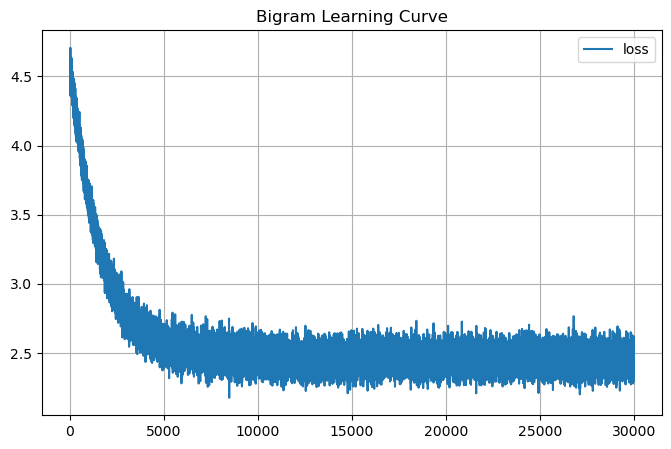

In [49]:
plt.figure(figsize=(8,5))
plt.plot(losses,label="loss")
plt.title("Bigram Learning Curve")
plt.grid()
plt.legend()
plt.show()

In [41]:
output = model.generate(X_test,100)

print(decode(output[0].tolist(),chars))

ht and gr tyoror?
GBEmil t-ham haces qured wh herd ithit:
pll ne n's, end l br am DUShou chel, doulous?

TI 


# Comparing the model parameters after training to a simple count based Bigram Model

In [87]:
count_embedding = np.zeros(shape=(vocab_size,vocab_size))

for t1,t2 in zip(train_data,train_data[1:]):
    count_embedding[t1,t2] += 1

normalized_counts = count_embedding/count_embedding.sum(1,keepdims=True)

In [89]:
logits, loss = model(torch.arange(vocab_size).view(1,vocab_size)),model(torch.arange(vocab_size).view(1,vocab_size))

model_distribution = F.softmax(logits[0][0],dim=1).detach().numpy()

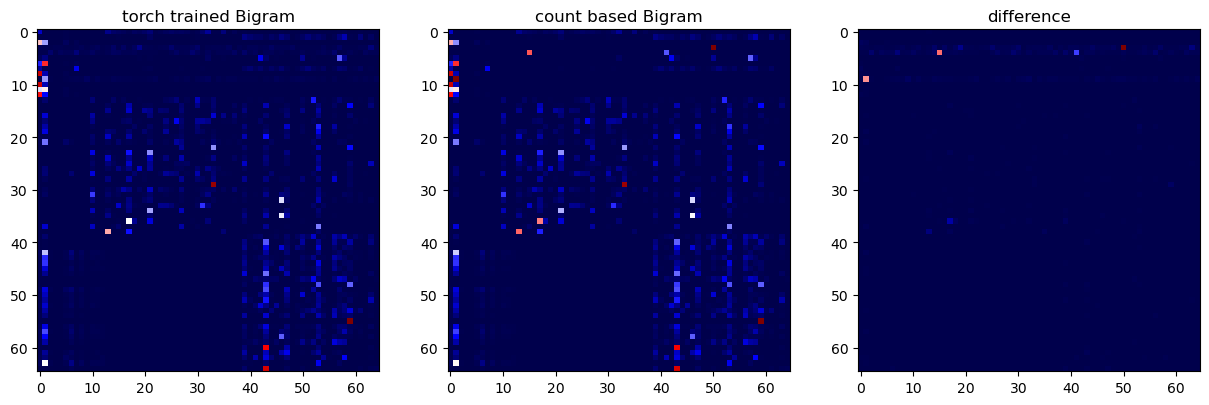

In [93]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].imshow(model_distribution, cmap="seismic")
ax[0].set(title="torch trained Bigram")

ax[1].imshow(normalized_counts, cmap="seismic")
ax[1].set(title="count based Bigram")

ax[2].imshow(np.abs(model_distribution-normalized_counts), cmap="seismic")
ax[2].set(title="difference")

plt.show()